##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic regression: Predict fuel efficiency

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/keras/regression"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/regression.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/regression.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/keras/regression.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的 [官方英文文档](https://tensorflow.google.cn/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到 [tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入 [docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

此教程使用经典的 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 数据集并演示了如何构建模型来预测 20 世纪 70 年代末和 20 世纪 80 年代初汽车的燃油效率。为此，您需要为模型提供该时期的许多汽车的描述。这种描述包括诸如气缸、排量、马力和重量等特性。

此示例使用了 Keras API。（请访问 Keras [教程](https://tensorflow.google.cn/tutorials/keras)和[指南](https://tensorflow.google.cn/guide/keras)以了解更多信息。）

In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
#precision=3: 设置打印输出时浮点数的精度为小数点后 3 位。这样，当打印浮点数时，只会显示小数点后 3 位，使输出更加简洁。
#suppress=True: 设置打印输出时是否禁止使用科学计数法。当 suppress=True 时，NumPy 将不使用科学计数法来表示很大或很小的数，而是以常规的十进制形式进行输出

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


## Auto MPG 数据集

该数据集可以从 [UCI机器学习库](https://archive.ics.uci.edu/ml/) 中获取.


### 获取数据

首先下载数据集。

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 数据清洗

数据集包含一些未知值：

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

为了保证此初始教程简单，请删除这些行：

In [7]:
dataset = dataset.dropna()

`"Origin"` 列为分类数据，而不是数值数据。因此，下一步是使用 [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) 对列中的值进行独热编码。

注：您可以设置 `tf.keras.Model` 来为您执行这种转换，但这超出了本教程的范围。有关示例，请参阅[使用 Keras 预处理层对结构化数据进行分类](../structured_data/preprocessing_layers.ipynb)或[加载 CSV 数据](../load_data/csv.ipynb)教程。

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### 将数据拆分为训练集和测试集

现在，将数据集拆分为训练集和测试集。您将在模型的最终评估中使用测试集。

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 数据检查

检查训练集中几对列的联合分布。

第一行表明燃油效率 (MPG) 是所有其他参数的函数。其他行表示它们是彼此的函数。

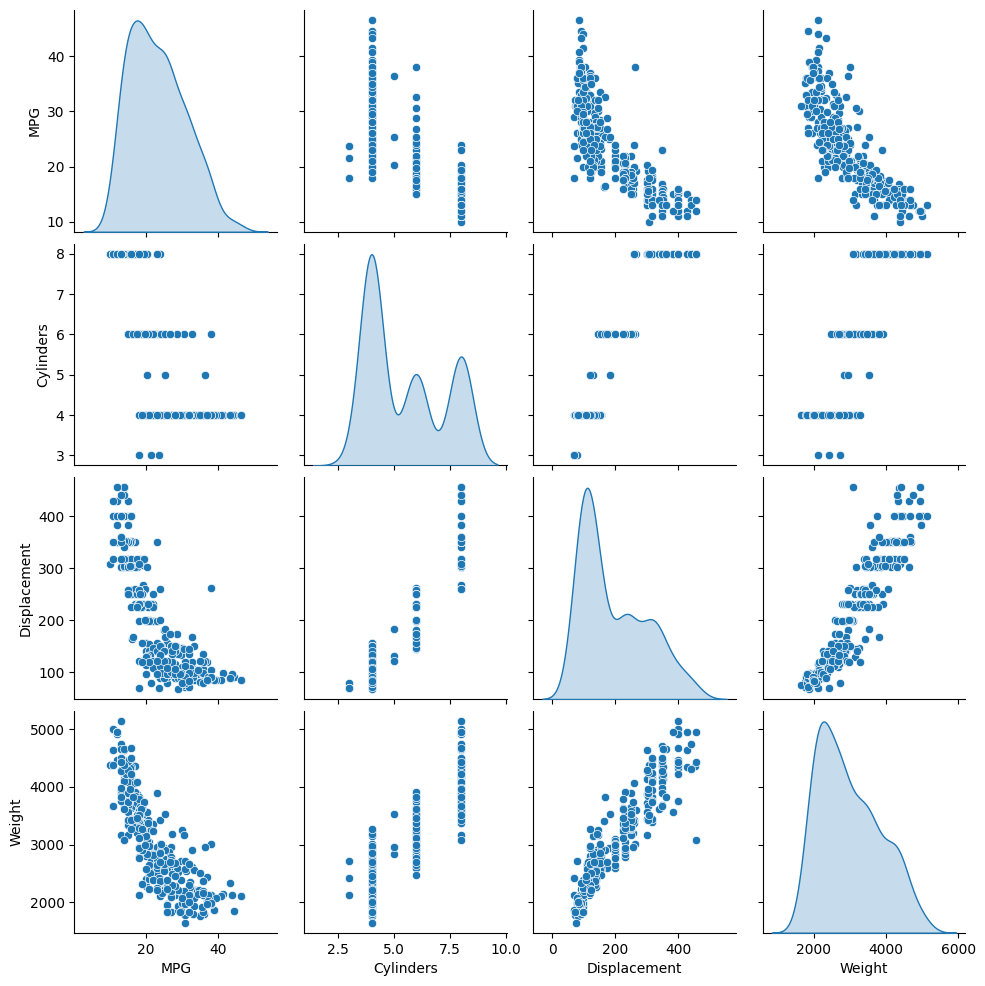

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

让我们也查看一下总体统计信息。请注意每个特征覆盖大为不同的范围：

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### 从标签中分离特征

将目标值（“标签”）从特征中分离。此标签是您训练模型来预测的值。

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## 归一化

在统计信息表中，可以很轻松地看到每个特征的范围的不同：

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


使用不同的尺度和范围对特征归一化是好的实践。尽管模型*可能* 在没有特征归一化的情况下收敛，它会使得模型训练更加复杂，并会造成生成的模型依赖输入所使用的单位选择。

归一化十分重要的一个原因是特征会与模型权重相乘。因此，输出尺度和梯度尺度受输入尺度的影响。

尽管模型*可能*在没有特征归一化的情况下收敛，但归一化会使训练更加稳定。

注：归一化独热特征没有任何好处，这里这样做是为了简单起见。有关如何使用预处理层的更多详细信息，请参阅[使用预处理层](https://tensorflow.google.cn/guide/keras/preprocessing_layers)指南和[使用 Keras 预处理层对结构化数据进行分类](../structured_data/preprocessing_layers.ipynb)教程。

### 归一化层

`tf.keras.layers.Normalization` 是一种将特征归一化添加到模型中的简洁且简单的方法。

第一步是创建层：

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

然后，通过调用 `Normalization.adapt` 以将预处理层的状态拟合到数据：

In [16]:
normalizer.adapt(np.array(train_features))

计算均值和方差，并将它们存储在层中。

In [17]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


当层被调用时，它会返回输入数据，每个特征将单独归一化：

In [18]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## 线性回归

在构建深度神经网络模型之前，首先使用一个和多个变量进行线性回归。

### 使用一个变量进行线性回归

从单变量线性回归开始，根据 `'Horsepower'` 预测 `'MPG'`。

使用 `tf.keras` 训练模型通常从定义模型架构开始。使用 `tf.keras.Sequential` 模型，它[表示一系列步骤](https://tensorflow.google.cn/guide/keras/sequential_model)。

单变量线性回归模型有两个步骤：

- 使用 `tf.keras.layers.Normalization` 预处理层规一化 `'Horsepower'` 输入特征。
- 应用线性变换 ($y = mx+b$) 以使用线性层 (`tf.keras.layers.Dense`) 生成 1 个输出。

*输入*的数量可以由 `input_shape` 参数设置，也可以在模型第一次运行时自动设置。

首先，创建一个由 `'Horsepower'` 特征构成的 NumPy 数组。然后，实例化 `tf.keras.layers.Normalization` 并将其状态拟合到 `horsepower` 数据：

In [19]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

构建 Keras 序贯模型：

In [20]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


此模型将根据 `'Horsepower'` 预测 `'MPG'`。

在前 10 个“马力”值上运行未经训练的模型。输出不会很好，但您会看到它具有预期的形状 `(10, 1)`：

In [21]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 131ms/step


array([[ 1.216],
       [ 0.687],
       [-2.245],
       [ 1.705],
       [ 1.542],
       [ 0.605],
       [ 1.827],
       [ 1.542],
       [ 0.402],
       [ 0.687]], dtype=float32)

构建模型后，使用 Keras `Model.compile` 方法配置训练过程。要编译的最重要参数是 `loss` 和 `optimizer`，因为它们定义了将要优化的内容 (`mean_absolute_error`) 以及优化的方法（使用 `tf.keras.optimizers.Adam`）。

In [22]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

使用 Keras `Model.fit` 执行 100 个周期的训练：

In [23]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 5.16 s, sys: 196 ms, total: 5.35 s
Wall time: 10.7 s


使用 `history` 对象中存储的统计信息呈现模型的训练进度：

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804961,4.188210,95
96,3.809077,4.206821,96
97,3.802470,4.189756,97
98,3.810097,4.153716,98
99,3.806584,4.182800,99


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

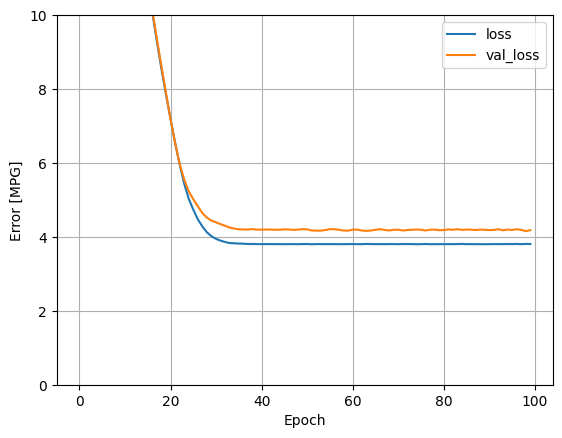

In [26]:
plot_loss(history)

收集测试集上的结果，供后面使用：

In [27]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

由于这是一个单变量回归，很容易将模型的预测视为输入的函数：

In [28]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


In [29]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

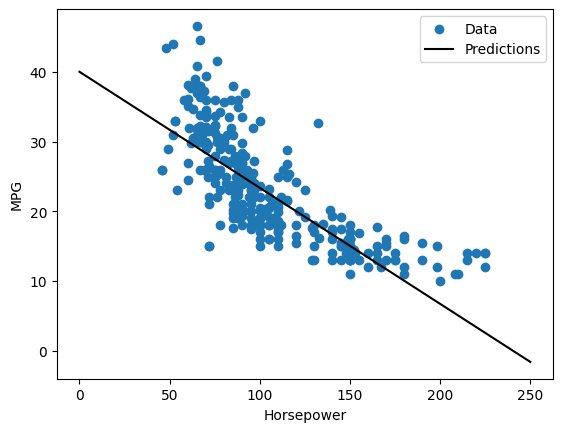

In [30]:
plot_horsepower(x, y)

### 使用多个输入进行线性回归

您可以使用几乎相同的设置根据多个输入进行预测。此模型仍然执行相同的 $y = mx+b$，只是 $m$ 是一个矩阵，而 $b$ 是一个向量。

再次创建一个两步 Keras 序贯模型，第一层为您之前定义并拟合到整个数据集的 `normalizer` (`tf.keras.layers.Normalization(axis=-1)`)：

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

当您对一批输入调用 `Model.predict` 时，它会为每个样本生成 `units=1` 输出。

In [36]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 67ms/step


array([[25.939],
       [24.739],
       [12.193],
       [31.221],
       [32.28 ],
       [22.423],
       [32.961],
       [25.291],
       [20.428],
       [26.408]], dtype=float32)

当您调用模型时，将构建其权重矩阵 – 可以看到 `kernel` 权重（$y=mx+b$ 中的 $m$）的形状为 `(9, 1)`：

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.555],
       [-0.326],
       [ 0.728],
       [-0.578],
       [ 0.354],
       [ 0.005],
       [ 0.163],
       [ 0.061],
       [ 0.405]], dtype=float32)>

使用 Keras `Model.compile` 配置模型并使用 `Model.fit` 训练 100 个周期：

In [34]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.98 s, sys: 177 ms, total: 5.16 s
Wall time: 5.58 s


使用此回归模型中的所有输入可以实现比 `horsepower_model`（具有一个输入）低得多的训练和验证误差：

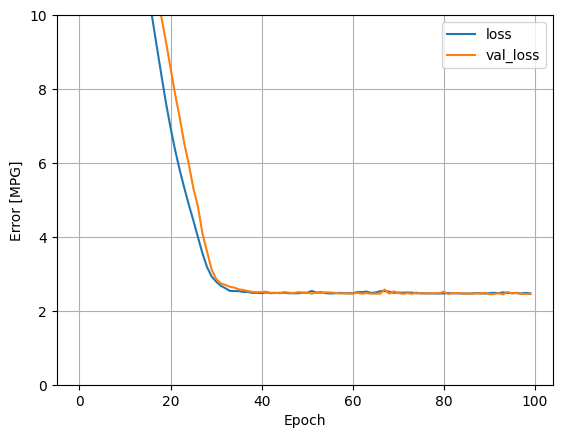

In [37]:
plot_loss(history)

收集测试集上的结果，供后面使用：

In [38]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## 使用深度神经网络 (DNN) 进行回归

在上一部分中，您为单输入和多输入实现了两个线性模型。

在此，您将实现单输入和多输入 DNN 模型。

除了将模型扩展为包括一些“隐藏”非线性层之外，代码基本相同。此处的名称“隐藏”仅表示不直接连接到输入或输出。

这些模型包含的层比线性模型多一些：

- 归一化层和以前一样（对于单输入模型使用 `horsepower_normalizer`，对于多输入模型使用 `normalizer`）。
- 使用 ReLU (`relu`) 激活函数非线性的两个隐藏非线性 `Dense` 层。
- 一个线性 `Dense` 单输出层。

两个模型都将使用相同的训练过程，因此 `compile` 方法包含在下面的 `build_and_compile_model` 函数中。

In [39]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### 使用 DNN 和单输入进行回归

创建一个 DNN 模型，仅将 `'Horsepower'` 作为输入，将 `'Horsepower'`（之前定义）作为归一化层：

In [40]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

此模型比线性模型的可训练参数多很多。

In [41]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


使用 Keras `Model.fit` 训练模型：

In [42]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.77 s, sys: 176 ms, total: 5.94 s
Wall time: 11 s


此模型略优于线性单输入 `horsepower_model`：

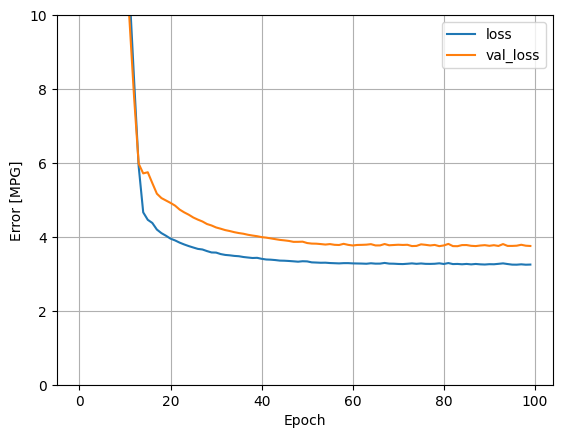

In [43]:
plot_loss(history)

如果您将预测值绘制为 `'Horsepower'` 的函数，应看到此模型如何利用隐藏层提供的非线性：

In [44]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


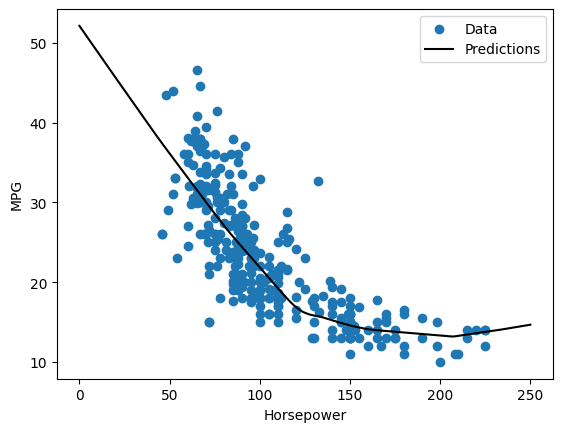

In [45]:
plot_horsepower(x, y)

收集测试集上的结果，供后面使用：

In [46]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### 使用 DNN 和多输入进行回归

使用所有输入重复前面的过程。模型的性能在验证数据集上会略有提高。

In [61]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 64)                640       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [48]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.21 s, sys: 189 ms, total: 5.4 s
Wall time: 5.75 s


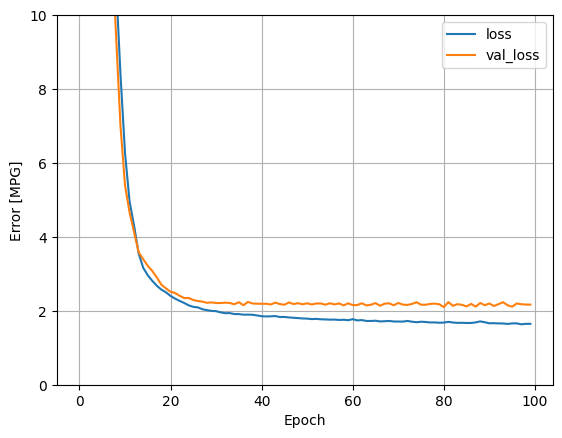

In [49]:
plot_loss(history)

收集测试集上的结果：

In [50]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## 性能

所有模型都已经过训练，因此您可以查看它们的测试集性能：

In [51]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.652507
linear_model,2.488970
dnn_horsepower_model,2.930623
dnn_model,1.710509


这些结果与训练期间看到的验证误差相匹配。

### 做预测

您现在可以使用 Keras `Model.predict`，在测试集上利用 `dnn_model` 进行预测并查看损失：

3/3 [==============================] - 0s 4ms/step


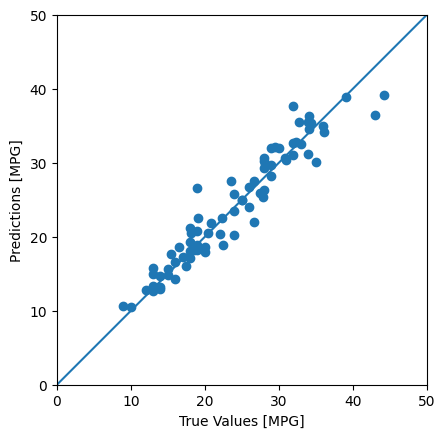

In [52]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


看起来模型预测得相当出色。

现在，查看一下误差分布：

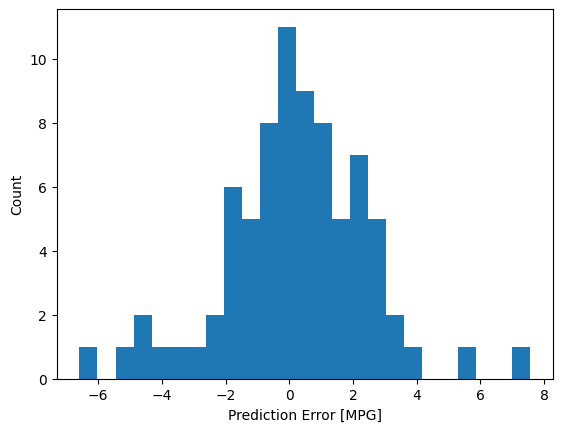

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

如果您对模型感到满意，请使用 `Model.save` 将其保存以备后续使用：

In [62]:
dnn_model.save('dnn_model.keras')

如果您重新加载模型，它会给出相同的输出：

In [63]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

ValueError: ignored

In [64]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.652507
linear_model,2.488970
dnn_horsepower_model,2.930623
dnn_model,1.710509


## 结论

本笔记本 (notebook) 介绍了一些处理回归问题的技术。

- 均方误差 (MSE) (`tf.keras.losses.MeanSquaredError`) 和平均绝对误差 (MAE) (`tf.keras.losses.MeanAbsoluteError`) 是用于回归问题的常见损失函数。MAE 对异常值不那么敏感。不同的损失函数用于分类问题。
- 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）。
- 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围。
- 过拟合是 DNN 模型的常见问题，但本教程不存在此问题。有关这方面的更多帮助，请访问[过拟合和欠拟合](overfit_and_underfit.ipynb)教程。